In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
import tabulate
import itertools
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
import umap
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import gget

# locals
import utils as ut
reload(ut)

sc.settings.verbosity = 3

2022-12-19 09:41:41.389079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 09:41:41.522810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-12-19 09:41:41.522835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-19 09:41:41.549273: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-19 09:41:42.3781

In [2]:
clusterPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/clusters.csv"
cf = pd.read_parquet(clusterPath)
print(cf.shape)
print(cf['cellType'].unique())
cf.head()

(427882, 7)
['Macrophages' 'B cells' 'Monocytes' 'NK cells' 'Dendritic cells'
 'T cells' 'Stromal cells']


,gene,scores,pvals,logfoldchanges,clusterId,key,cellType
0,H2-EB1,36.343353,4.575346e-181,3.564091,1,ND,Macrophages
1,H2-AA,35.311523,4.761517e-183,3.430534,1,ND,Macrophages
2,H2-AB1,34.411163,2.815112e-177,3.234597,1,ND,Macrophages
3,CD74,33.910587,2.451588e-177,3.302062,1,ND,Macrophages
4,H2-DMA,31.695400,2.991793e-123,2.667091,1,ND,Macrophages


In [3]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/"

adata = {}

for f in os.listdir(dirPath):
    
    if not f == "all":
        key = f
        mtxPath = f"{dirPath}{f}/outs/"
        data = sc.read_visium(mtxPath)
        data.var_names_make_unique()
        data.var_names = [x.upper() for x in data.var_names]
        adata[key] = data
    
adata.keys()

reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/HFD14/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/ND/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/HFD8/outs/filtered_feature_bc_matrix.h5
 (0:00:00)


dict_keys(['HFD14', 'ND', 'HFD8'])

# Filtering

In [4]:
"""SPTX filtering """

keys = ['ND', 'HFD8', 'HFD14']

min_counts = 5

for key in keys:
    print(key)
    data = adata[key]
    sc.pp.filter_cells(data, min_counts=min_counts)
    sc.pp.normalize_total(data, target_sum=1e4) # Normalize each cell by total counts over all genes
    sc.pp.log1p(data) # Logarithmize data via `X = \log(X + 1)`,
    sc.pp.scale(data) # unit variance and zero mean


ND
filtered out 1 cells that have less than 5 counts
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
HFD8
filtered out 1 cells that have less than 5 counts
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
HFD14
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [5]:
""" leiden clustering """
n_comps = 40
resolution = 0.75

for key in keys:
    data = adata[key]
    data.layers["counts"] = data.X.copy()
    sc.pp.pca(data, n_comps)
    sc.pp.neighbors(data)
    sc.tl.umap(data)
    sc.tl.leiden(data, resolution=resolution)
    
print('done.')

computing PCA
    with n_comps=40
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing PCA
    with n_comps=40
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categor

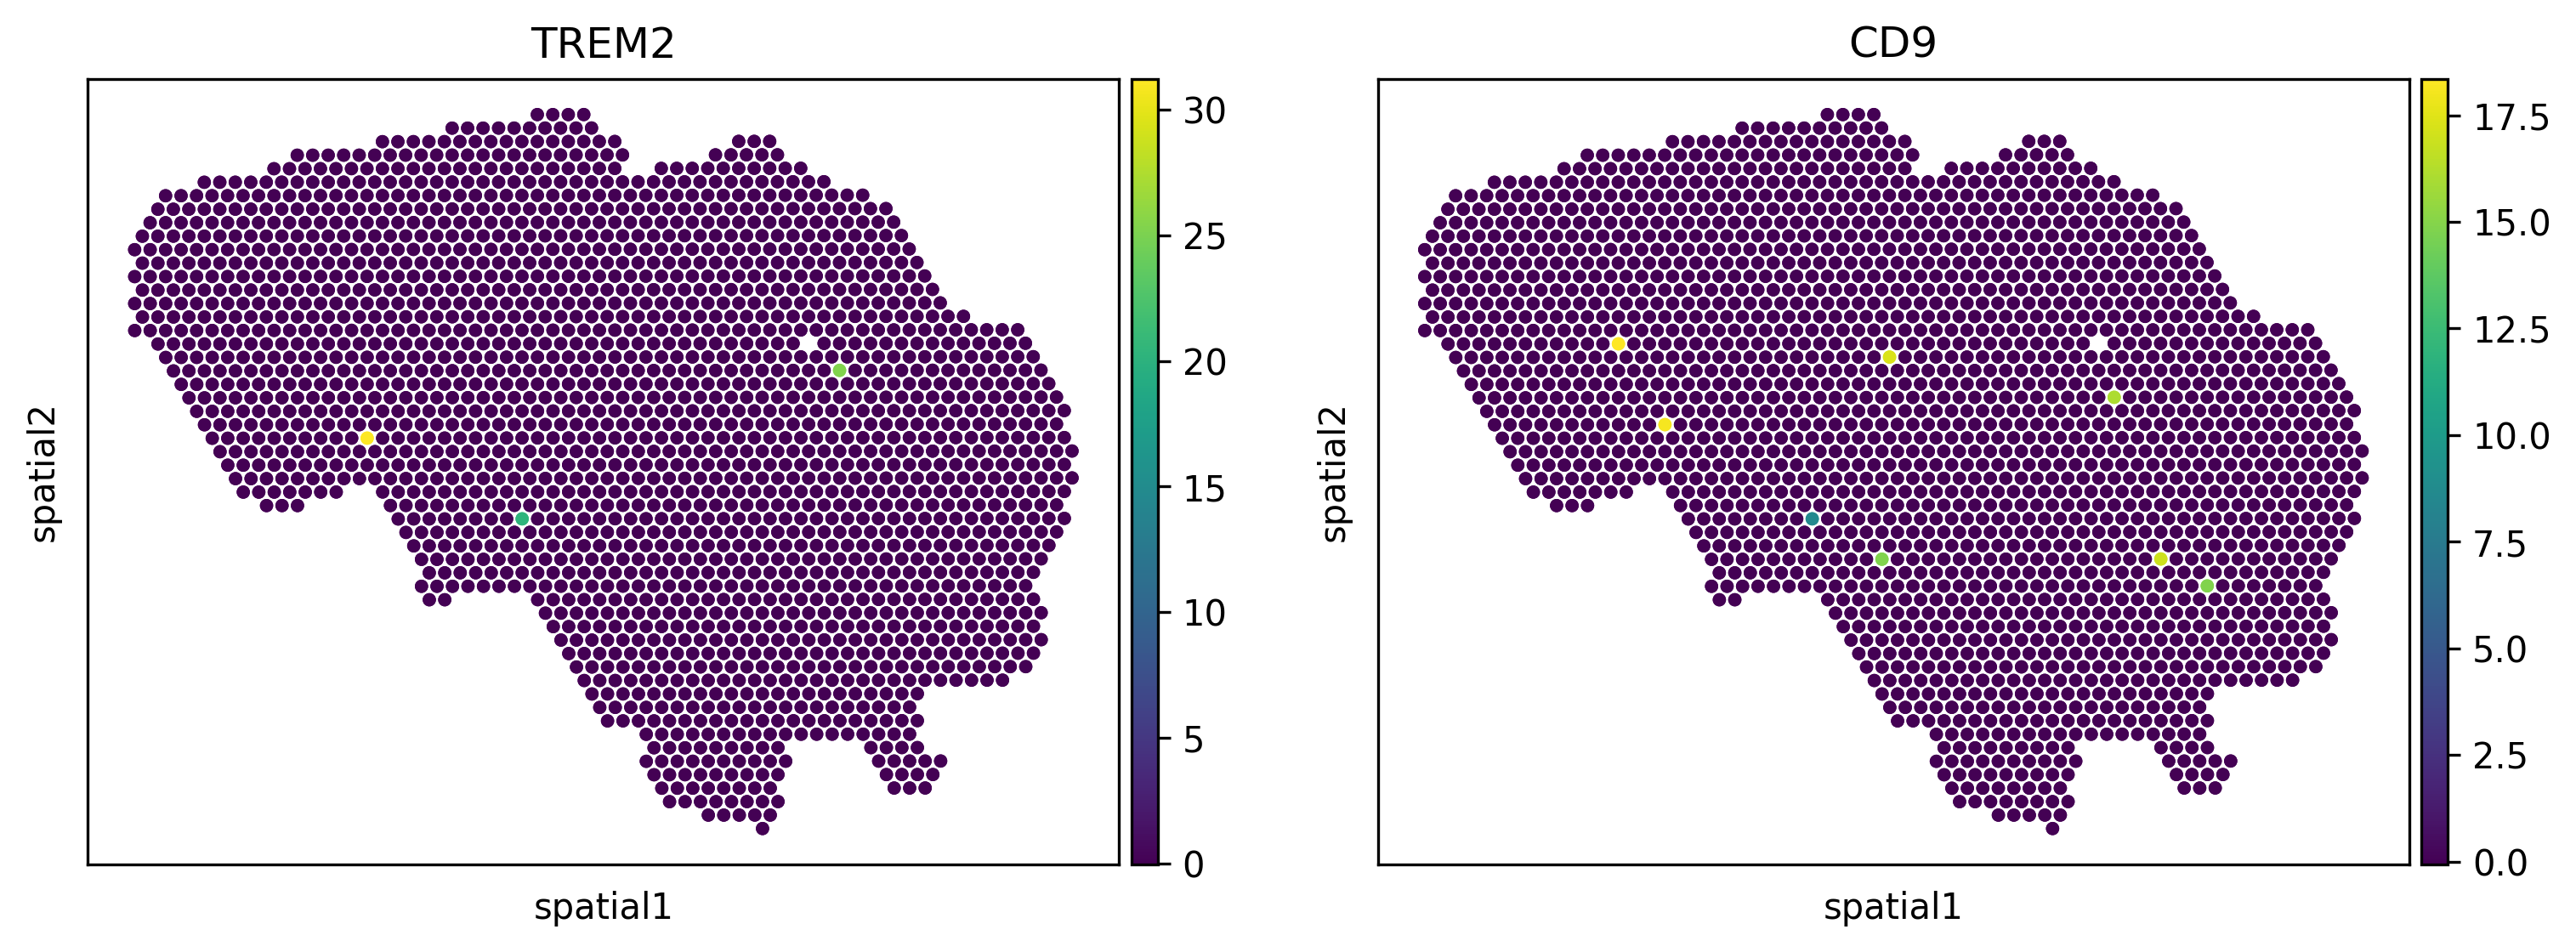

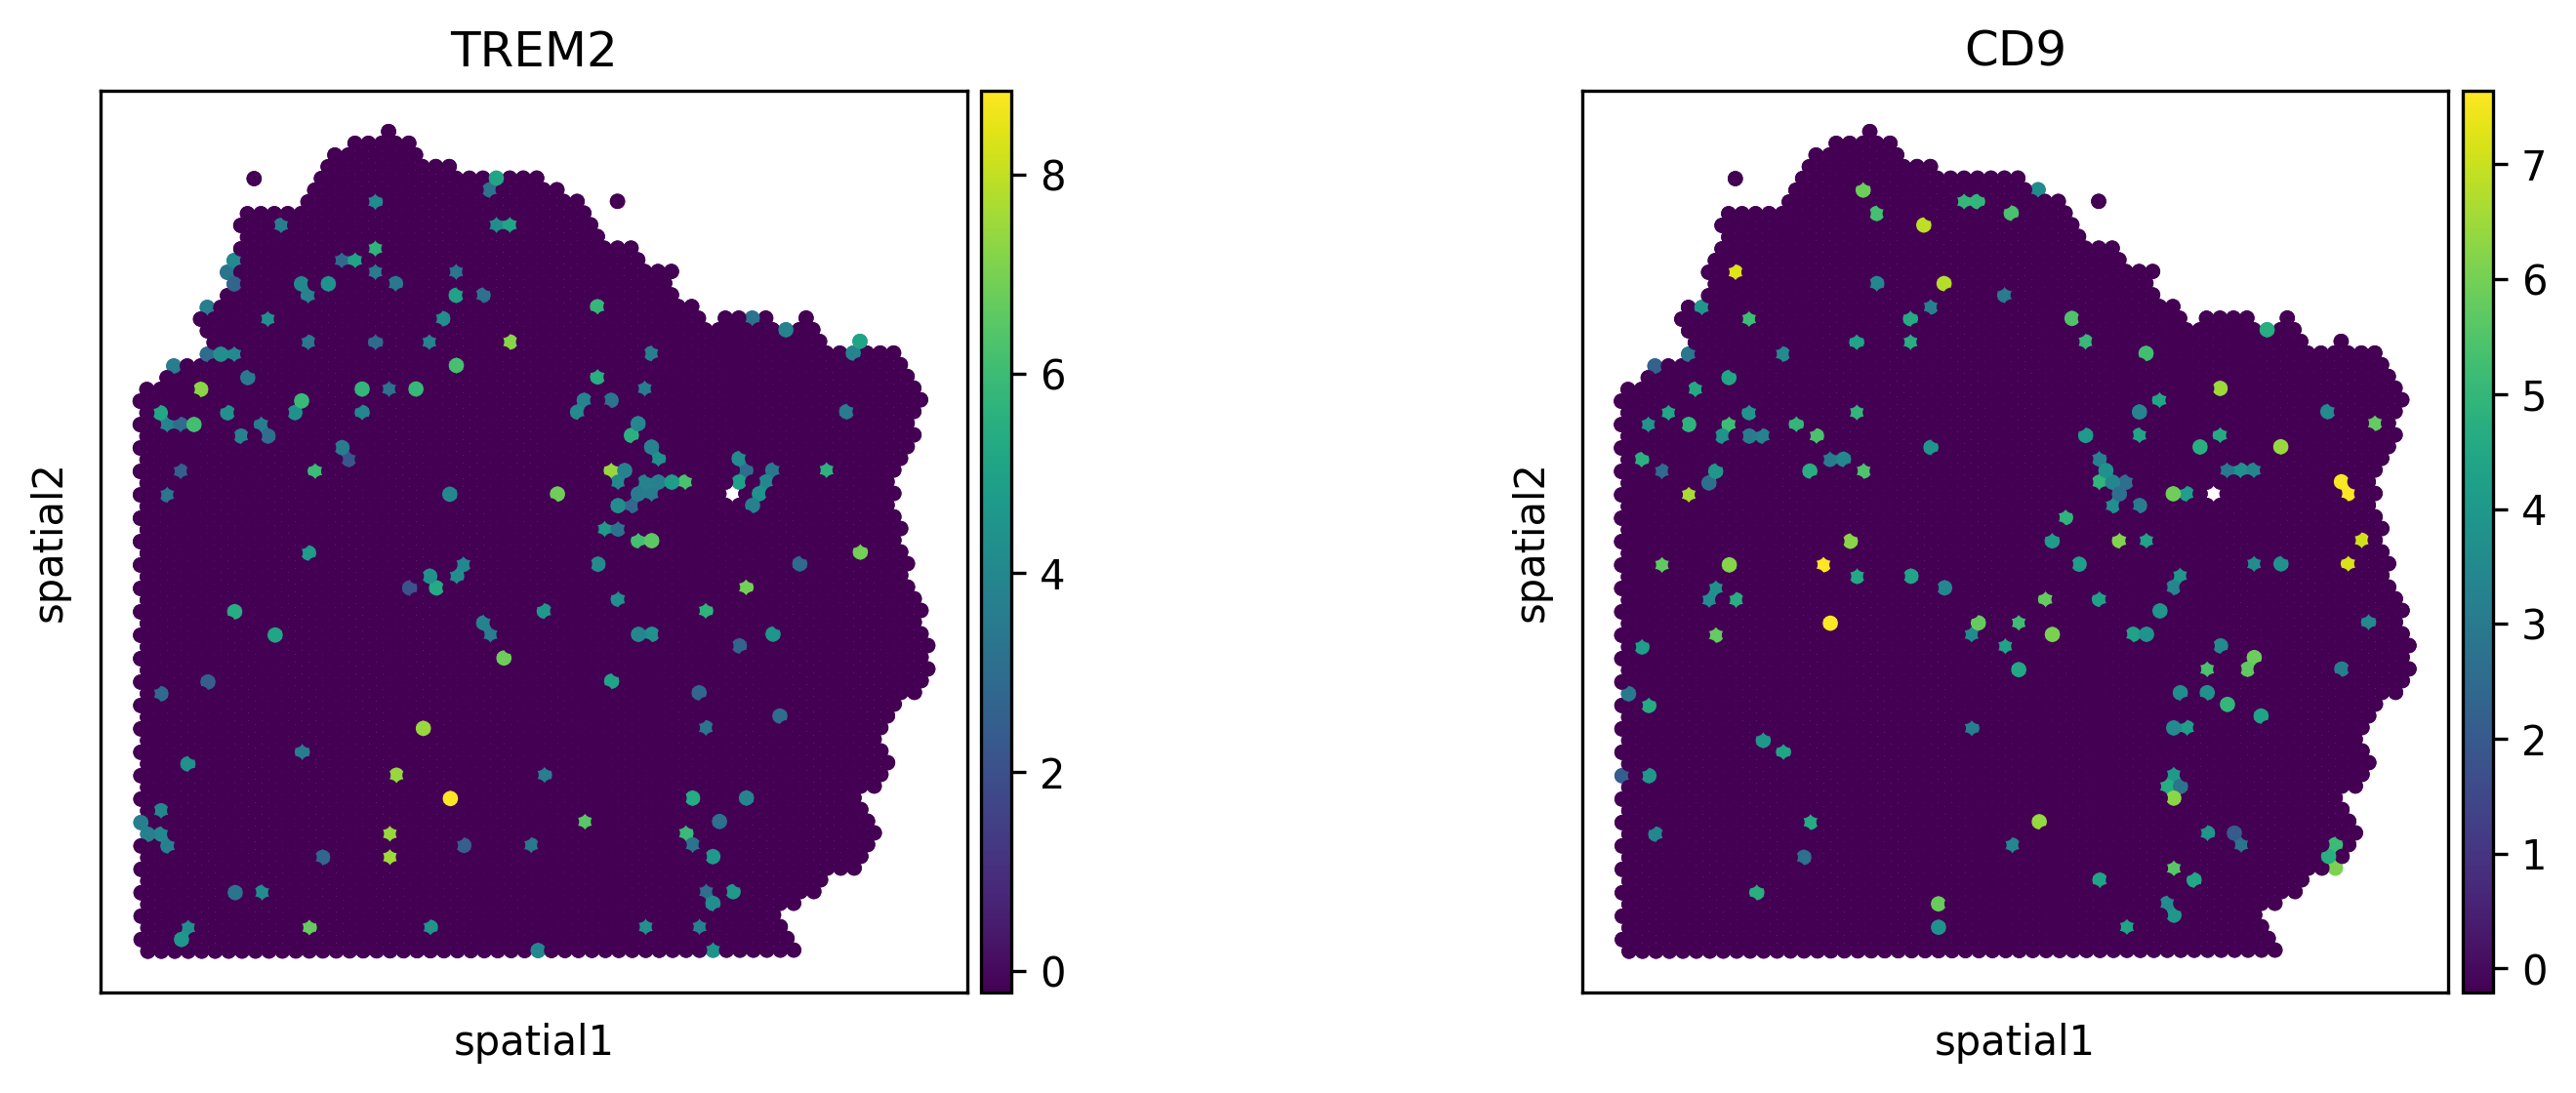

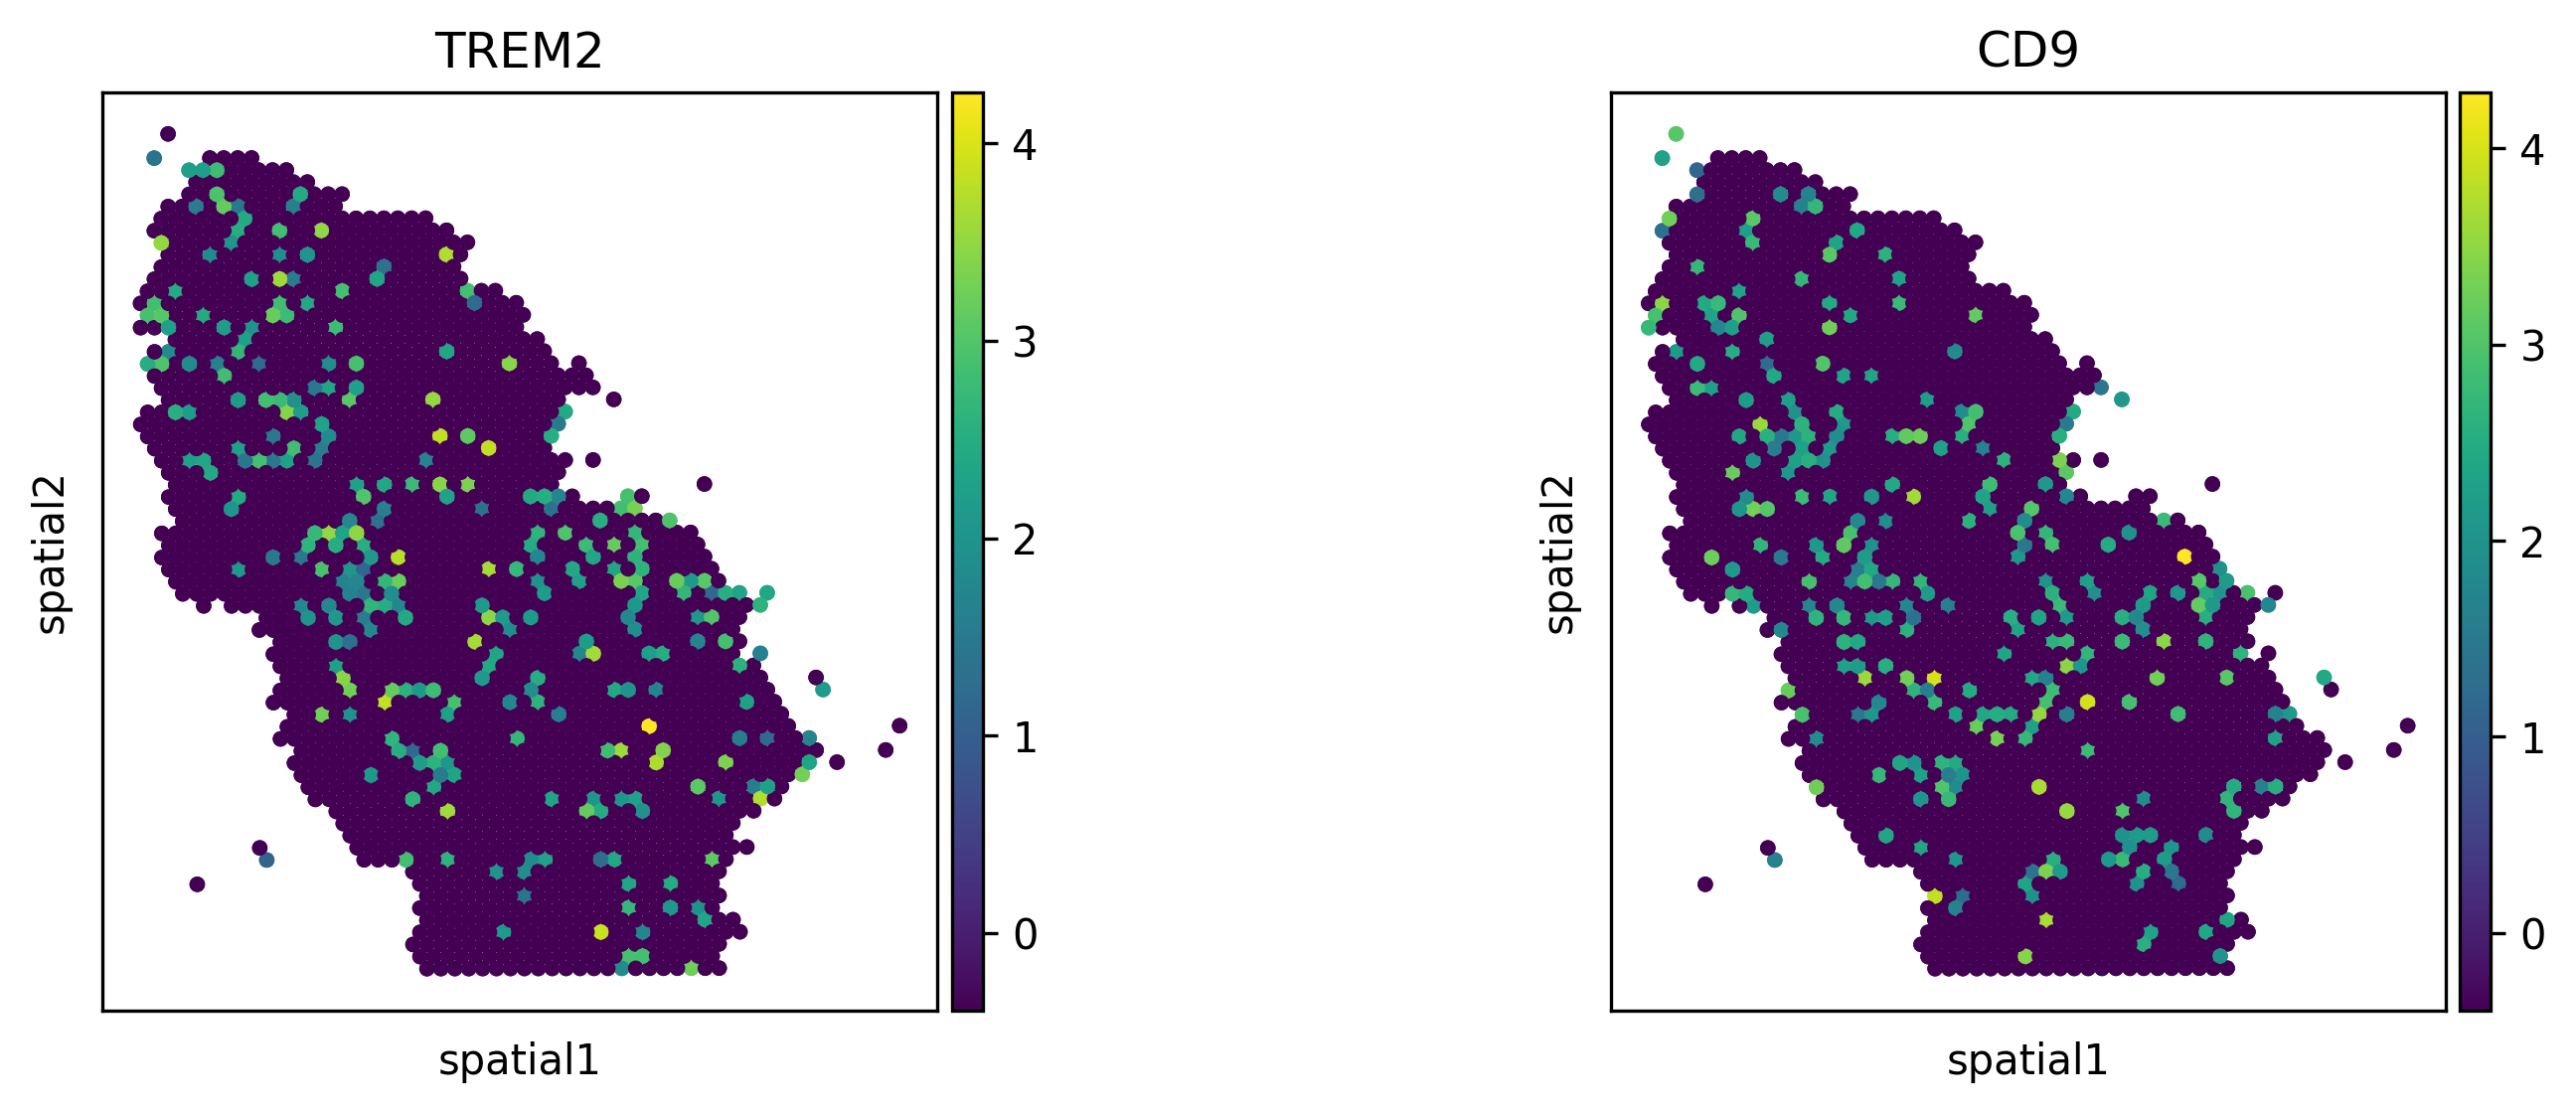

In [18]:
for key in keys:
    data = adata[key]
        
    plt.rcParams['figure.facecolor'] = 'w'
    plt.rcParams['figure.dpi'] = 300
    sq.pl.spatial_scatter(data, 
                          library_id="spatial",
                          shape=None,
                          color=['TREM2', 'CD9'], 
                          wspace=0.04,
                          size=30,
                          img=True,)
    

    plt.show()
    # break

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = 'w'

lft = 1
nGene = 30
alpha = 0.05
q = 20
layer = 6 # reverse ordered from 6 to 0 with 6 == 1 first layer

for key in keys:
    data = adata[key]
    # get the image and the scale factors
    img, scale_factor = getImage(data)
    df = data.to_df()
    
    # get the image coordinates and scale them
    coords = data.obsm['spatial']
    x = coords[:, 0]
    y = coords[:, 1]
    x = x * scale_factor 
    y = y * scale_factor 
    
    # get marker genes for cell types
    rf = cf[cf['key'] == key]
    rf = rf[rf['pvals'] <= alpha].reset_index(drop=True)
    
    rf = rf.groupby(['gene', 'cellType']).agg(
        clusterCount = ('clusterId', 'count'),
        meanLFC = ('logfoldchanges', 'mean')
    ).reset_index(drop=False)
    
    rf = rf[rf['meanLFC'] > lft].reset_index(drop=True)        
    rf = rf.set_index('gene')
    rf = rf.groupby(['cellType'])['clusterCount'].nlargest(nGene).reset_index(drop=False)
    rf['flag'] = 1.0
    
    # print(rf.head())
    # print(rf['cellType'].value_counts())
    
    rf = pd.pivot_table(rf, values='flag',
                        index='gene', 
                        columns='cellType')
    
    rf = rf.fillna(0.0)

    dfT = df.T
    # binarize the spot data
    spots = dfT.columns
    
    spotDecon = pd.merge(dfT, rf,
                         how='left',  
                         left_on=dfT.index,
                         right_on=rf.index,)
    
    spotDecon = spotDecon.fillna(0)
    """ Deconvolute the spots """
    
    spotColor = []
    spotTypes = []
    for spot in spots:
        spotThresh = np.percentile(spotDecon[spot], q)
        spotVec = np.where(spotDecon[spot] > spotThresh, 1.0, 0.0)
        scores = []
        for c in ctypes:
            
            score = metrics.jaccard_score(spotDecon[c], spotVec)
            scores.append(score)
        
        indx = np.argsort(scores)
        i = np.nonzero(indx == layer)[0][0]
        spotType = ctypes[i]
        spotColor.append(colorDict[spotType])
        spotTypes.append(spotType)
        
    print(pd.Series(spotTypes).value_counts())
        
    handles = []
    for ctype in ctypes:
        handle = mpatches.Patch(color=colorDict[ctype], 
                                ec='k', 
                                label=ctype)
        handles.append(handle)
        
    plt.scatter(x, y,
                c=spotColor,
                marker="o",
                edgecolor="None",
                # lw=0.1,
                zorder=2,
                alpha=0.7,
                s=60)
    
    # plt.imshow(img.astype(float), 
    #        interpolation='none',
    #        cmap='binary',
    #        alpha=0.7,
    #        zorder=1)
    
    xlim = trim[key]['xlim']
    ylim = trim[key]['ylim']
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.yticks([])
    plt.xticks([])
    
    plt.legend(handles=handles, bbox_to_anchor=(1.04, 1.02))
    plt.title(key)
    plt.show()
    
    break

In [ ]:
ctypes

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = 'w'

expT = 0 # gene expression threshold


for key in keys:
    data = adata[key]
    # get the image and the scale factors
    img, scale_factor = getImage(data)
    df = data.to_df()
    
    # get the image coordinates and scale them
    coords = data.obsm['spatial']
    x = coords[:, 0]
    y = coords[:, 1]
    x = x * scale_factor 
    y = y * scale_factor 
    
    spotType = []
    
    for idx, row in df.head(10).iterrows():
        mask = row > expT
        expressedGenes = df.columns[mask]
        
        ef = gget.enrichr(expressedGenes, database='PanglaoDB_Augmented_2021')
        predType = ef.head(1)['path_name'].values[0]
        spotType.append(predType)
        
    
    print(pd.Series(spotType).value_counts())

   
        
#     handles = []
#     for ctype in ctypes:
#         handle = mpatches.Patch(color=colorDict[ctype], 
#                                 ec='k', 
#                                 label=ctype)
#         handles.append(handle)
        
#     plt.scatter(x, y,
#                 c=spotColor,
#                 marker="o",
#                 edgecolor="None",
#                 # lw=0.1,
#                 zorder=2,
#                 alpha=0.7,
#                 s=60)
    
#     # plt.imshow(img.astype(float), 
#     #        interpolation='none',
#     #        cmap='binary',
#     #        alpha=0.7,
#     #        zorder=1)
    
#     xlim = trim[key]['xlim']
#     ylim = trim[key]['ylim']
#     plt.xlim(xlim)
#     plt.ylim(ylim)
#     plt.yticks([])
#     plt.xticks([])
    
#     plt.legend(handles=handles, bbox_to_anchor=(1.04, 1.02))
#     plt.title(key)
#     plt.show()
    
    break